In [19]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [20]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)

In [21]:
def barrier_and_grad(x, y, L, epsilon=1e-4):
    def soft_repel(s, Ls):
        return 1 / (s + epsilon) + 1 / (Ls - s + epsilon)
    
    def grad_soft_repel(s, Ls):
        return -1 / (s + epsilon)**2 + 1 / (Ls - s + epsilon)**2

    B = soft_repel(x, L[0]) + soft_repel(y, L[1])
    dBx = grad_soft_repel(x, L[0])
    dBy = grad_soft_repel(y, L[1])
    return B, np.array([dBx, dBy])

In [22]:
# Configure the index vectors
num_k_per_dim = 50
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T
# Pre-processing lambda_k and h_k
#lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0) # Fourier
lamk_list = np.ones(ks.shape[0]) # Radial, Indicator
hk_list = np.zeros(ks.shape[0])


# compute the coefficients for the target distribution Radial

## Radial
### Radial basis have the challenging tradeoff when too large they lack discrimination (in practice i.e finite in number)
### when too small they vanish almost everywhere and have poor generalization capabilities, that why we add usually 1 high variance rbf with lower weight to ensure stability of the algorithmn
sigmas = np.array([0.01,0.1,0.5]) ### Parameter of radial basis
weights = 1 / sigmas**2
weights /= np.sum(weights)
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
centers = np.zeros(ks.shape)
for i, k_vec in enumerate(ks):
    center = np.array([1 /(num_k_per_dim + 1) * (k_vec[0] + 1),  1/(num_k_per_dim + 1) * (k_vec[1] + 1)])
    centers[i] = center
    ## Try sum of radials for more stability
    sq_dists = np.sum((grids - center)**2, axis=-1)
    sigmas = np.array(sigmas).reshape(-1, 1)
    weights = np.array(weights).reshape(-1, 1)
    rbfs = np.exp(-sq_dists / (2 * sigmas**2))
    fk_vals = np.sum(weights * rbfs, axis=0)
    
    #fk_vals = np.exp(-(np.sum((grids - center)**2, axis = -1))/(2 * sigma**2))
    #print(fk_vals.shape)
    
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik

#### Smooth Indicator
"""alpha = 15
def sig(x,a, alpha = alpha):
    return 1 / (1 + np.exp(-alpha * (x - a)))

def d_sig(x, a, alpha = alpha):
    s = sig(x, a, alpha)
    return alpha * s * (1 - s)

lower = np.zeros(ks.shape)
upper = np.zeros(ks.shape)
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, k_vec in enumerate(ks):
    a = np.array([1 /(num_k_per_dim) * (k_vec[0]),  1/(num_k_per_dim) * (k_vec[1])])
    b = np.array([1 /(num_k_per_dim) * (k_vec[0] + 1),  1/(num_k_per_dim) * (k_vec[1] + 1)])
    lower[i] = a
    upper[i] = b
    f1 = sig(grids,a)
    f2 = sig(grids,b)
    fk_vals = np.prod(f1 * (1 - f2), axis=-1)
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    phik_list[i] = phik"""

#Normalization Constant Fourier
# For gaussian sensor distribution Makes Cov = diag(var_1, var_2)
"""for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk
# compute the coefficients for the target distribution Fourier
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    fk_vals /= hk
    phik = np.sum(fk_vals * pdf_vals) * dx * dy 
    phik_list[i] = phik"""

'for i, k_vec in enumerate(ks):\n    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  \n    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)\n    hk_list[i] = hk\n# compute the coefficients for the target distribution Fourier\nphik_list = np.zeros(ks.shape[0])  \npdf_vals = pdf(grids)\nfor i, (k_vec, hk) in enumerate(zip(ks, hk_list)):\n    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  \n    fk_vals /= hk\n    phik = np.sum(fk_vals * pdf_vals) * dx * dy \n    phik_list[i] = phik'

In [23]:
from scipy.spatial.distance import cdist
from numpy.linalg import solve
def safe_log_div(p, q):
    """Compute p * log(p / q) safely."""
    mask = (p > 0) & (q > 0)
    return np.sum(p[mask] * np.log(p[mask] / q[mask]))

def compare_pdfs(pdf1, pdf2, epsilon=1e-12):
    # Flatten and add epsilon
    p = pdf1.ravel().astype(float) + epsilon
    q = pdf2.ravel().astype(float) + epsilon ## empirical one

    # Normalize to sum to 1
    p /= np.sum(p)
    q /= np.sum(q)
    m = 0.5 * (p + q)

    results = {
        "L2 distance": np.linalg.norm(p - q),
        "Total Variation": 0.5 * np.sum(np.abs(p - q)),
        "KL(p || q)": safe_log_div(p, q),
        "KL(q || p)": safe_log_div(q, p),
        "Jensen-Shannon": 0.5 * (safe_log_div(p, m) + safe_log_div(q, m)),
        "Cosine similarity": np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))
    }

    return results

def reconstruct_fourier(coeffs, hk_list, ks, grids):
    phi_recon = np.zeros(grids.shape[0])
    for i, (k_vec, ck, hk) in enumerate(zip(ks, coeffs, hk_list)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        fk_vals /= hk
        phi_recon += ck * fk_vals
    return phi_recon

def reconstruct_radial_basis(coeffs, weights, sigmas, centers, grids):
    M = centers.shape[0]
    N = sigmas.shape[0]
    d = centers.shape[1]
    pairwise_centers = cdist(centers, centers, 'sqeuclidean')  # shape (M, M)
    G = np.zeros((M, M))
    for i in range(N):
        for m in range(N):
            coef = (np.sqrt(np.pi) * np.sqrt(2 * sigmas[i]**2 * sigmas[m]**2 / (sigmas[i]**2 + sigmas[m]**2)))**d
            exp_term = np.exp(-pairwise_centers / (2 * (sigmas[i]**2 + sigmas[m]**2)))
            G += weights[i] * weights[m] * coef * exp_term
    rhs = np.zeros(M)
    for i in range(N):
        coef = (np.sqrt(np.pi) * np.sqrt(2) * sigmas[i])**d
        rhs += weights[i] * coef * coeffs
    c = np.linalg.solve(G + 1e-6 * np.eye(M), rhs)
    
    sq_dists = cdist(grids, centers, 'sqeuclidean')
    rbf_vals = np.zeros((grids.shape[0], M))
    for i in range(N):
        rbf_vals += weights[i] * np.exp(-sq_dists / (2 * sigmas[i]**2))
    
    phi_recon = rbf_vals @ c
    return phi_recon

def reconstruct_Indicator(coeffs):
    fks = np.zeros((grids.shape[0], len(ks)))
    for i,_ in enumerate(ks):
        f1 = sig(grids,lower[i])
        f2 = sig(grids,upper[i])
        fks[:, i] = np.prod(f1 * (1 - f2), axis=-1)

    # Compute Gram matrix and RHS vector
    G = fks.T @ (fks * dx * dy)
    # Solve for coefficients
    c = np.linalg.solve(G + 1e-6 * np.eye(G.shape[0]), coeffs)
    phi_recon = fks @ c
    return phi_recon
    
    

In [24]:
def barrier_and_grad(x, y, L, epsilon=1e-4):
    def soft_repel(s, Ls):
        return 1 / (s + epsilon) + 1 / (Ls - s + epsilon)
    
    def grad_soft_repel(s, Ls):
        return -1 / (s + epsilon)**2 + 1 / (Ls - s + epsilon)**2

    B = soft_repel(x, L[0]) + soft_repel(y, L[1])
    dBx = grad_soft_repel(x, L[0])
    dBy = grad_soft_repel(y, L[1])
    return B, np.array([dBx, dBy])

In [25]:
# Specify the dynamic system 
N_agents = 3
dt = 0.01
tsteps = 5001
ud = 0.2  # desired velocity 0.2 m/s
results_fourier = []

def dyn(xt, ut):
    xdot = ut 
    return ut

def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)
    return xt_new 

phik_list *= N_agents
phik_list_expanded = np.repeat(phik_list[:, None], N_agents, axis=1) / N_agents
# start SMC iteration
xt = np.random.uniform(low=0.2, high=0.8, size=(2,N_agents)) # inital state
#xt = np.array([0.5,0.5]) # for fair comparison!
x_traj = np.zeros((tsteps, 2, N_agents)) # trajectory
ck_list_update = np.zeros((ks.shape[0], N_agents))  # trajectory coefficients (update over time, not normalized)
cK_lists = []
metric_log = []  # record ergodic metric at each step
timeit = []
M = phik_list.shape[0]
S_list = [np.zeros((M, M)) for _ in range(N_agents)]

for t in range(tsteps):

    barrier_weight = 0.0 #<- RBF
    B_val, dB = barrier_and_grad(xt[0,:], xt[1,:], L_list)


    rbfs = np.exp(-np.sum((xt[np.newaxis, :, :] - centers[:, :, np.newaxis])**2, axis=1) / (2 * (sigmas[:, np.newaxis]**2)))
    fk_xt_all = np.sum(weights[:, None] * rbfs, axis=0)
    
    ck_list_update += fk_xt_all * dt


    dfk_xt_all = np.zeros((*ks.shape, N_agents))  # Initialize

    for sigma, w in zip(sigmas, weights):
        diff = xt[np.newaxis, :, :] - centers[:, :, np.newaxis]  # (2500, 2, N_agents)
        coeff = -w * (sigma ** (-2))
        fk_exp = fk_xt_all[:, np.newaxis, :] 
        dfk_xt_all += coeff * diff * fk_exp
    dfk_xt_all = dfk_xt_all.transpose(1,0,2)

    bt = np.sum(lamk_list[:, None] * ((ck_list_update / (t*dt + dt)) - phik_list_expanded) * dfk_xt_all, axis=1) + barrier_weight * dB
    ut = -ud * bt / (np.linalg.norm(bt, axis=0) + 1e-8)
    # step 5: execute the control, move on to the next iteration
    xt = step(xt, ut)
    x_traj[t] = xt.copy()
    erg_metric = np.sum(np.square((np.sum(ck_list_update / (t*dt + dt), axis = -1) - phik_list)))
    metric_log.append(erg_metric)
    if t % 1000 == 0:     
        print(f"Step {t}, Position: {xt[:2,1]}, Metric: {erg_metric:.5f}")  

Step 0, Position: [0.5105 0.7904], Metric: 2.85762


KeyboardInterrupt: 

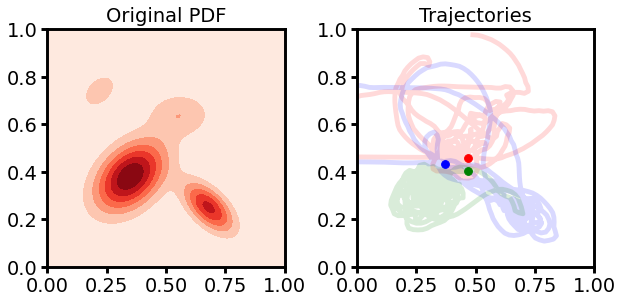

In [ ]:
import matplotlib.cm as cm
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
#fig, axes = plt.subplots(figsize=(6, 4), dpi=100, tight_layout=True) #### For now only one plot as i do not wish to reconstruct.
ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
distinct_colors = [
    'red', 'blue', 'green', 'orange', 'purple',
    'cyan', 'magenta', 'brown', 'olive', 'black',
    'pink', 'teal', 'navy', 'gold', 'lime',
    'coral', 'indigo', 'turquoise', 'maroon', 'gray'
]
ax = axes[1]
ax.set_title('Trajectories')
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
for i in range(N_agents):
    color = distinct_colors[i % len(distinct_colors)]
    ax.plot(x_traj[::10, 0, i], x_traj[::10, 1, i], linestyle='-', marker='', color=color, alpha=0.15, label=f'Trajectory {i}')
    ax.plot(x_traj[0, 0, i], x_traj[0, 1, i], linestyle='', marker='o', markersize=8, color=color, alpha=1.0, label=f'Init {i}')
#ax.legend(loc=1)

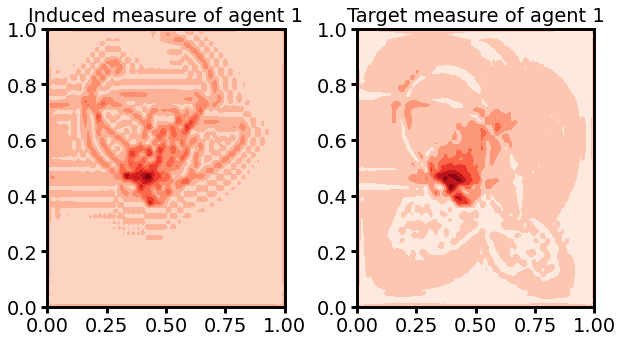

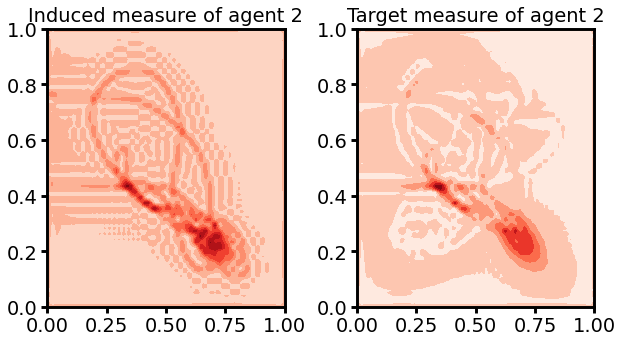

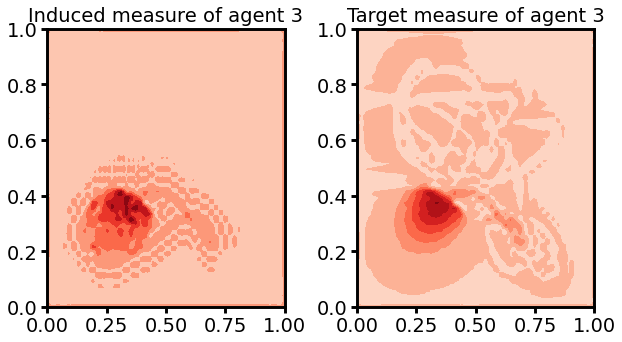

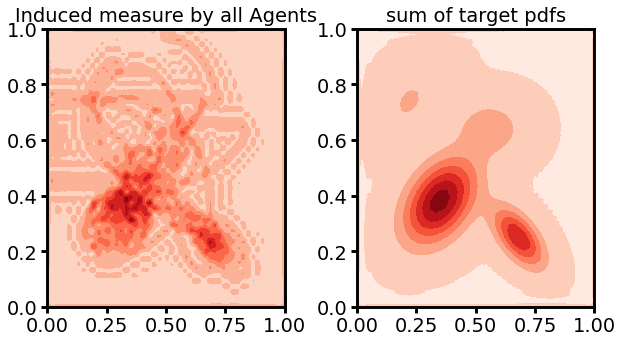

In [ ]:
all_phi = np.zeros(grids.shape[0])
all_phi_target = np.zeros(grids.shape[0])
for agent in range(N_agents):
    M = centers.shape[0]
    N = sigmas.shape[0]
    d = centers.shape[1]
    pairwise_centers = cdist(centers, centers, 'sqeuclidean')  # shape (M, M)
    G = np.zeros((M, M))
    for i in range(N):
        for m in range(N):
            coef = (np.sqrt(np.pi) * np.sqrt(2 * sigmas[i]**2 * sigmas[m]**2 / (sigmas[i]**2 + sigmas[m]**2)))**d
            exp_term = np.exp(-pairwise_centers / (2 * (sigmas[i]**2 + sigmas[m]**2)))
            G += weights[i] * weights[m] * coef * exp_term
    
    rhs = np.zeros(M)
    rhs_target = np.zeros(M)
    for i in range(N):
        coef = (np.sqrt(np.pi) * np.sqrt(2) * sigmas[i])**d
        rhs += weights[i] * coef * ck_list_update[:,agent] / (tsteps * dt)
        rhs_target += weights[i] * coef * phik_list_expanded[:,agent]
    c = np.linalg.solve(G, rhs)
    c_target = np.linalg.solve(G, rhs_target)
    sq_dists = cdist(grids, centers, 'sqeuclidean')
    rbf_vals = np.zeros((grids.shape[0], M))
    for i in range(N):
        rbf_vals += weights[i] * np.exp(-sq_dists / (2 * sigmas[i]**2))
    phi_recon = rbf_vals @ c
    phi_recon_target = rbf_vals @ c_target
    all_phi += phi_recon
    all_phi_target += phi_recon_target
    fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
    ax = axes[0]
    ax.set_xlim(0.0, L_list[0])
    ax.set_ylim(0.0, L_list[1])
    ax.set_title(f"Induced measure of agent {agent + 1}")
    ax.contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Reds')
    ax = axes[1]
    ax.set_xlim(0.0, L_list[0])
    ax.set_ylim(0.0, L_list[1])
    ax.set_title(f"Target measure of agent {agent + 1}")
    #print(phi_recon.sum(), phi_recon_target.sum())
    ax.contourf(grids_x, grids_y, phi_recon_target.reshape(grids_x.shape), cmap='Reds')
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
ax = axes[0]
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
all_phi /= N_agents
ax.set_title(f"Induced measure by all Agents")
ax.contourf(grids_x, grids_y, all_phi.reshape(grids_x.shape), cmap='Reds')
ax = axes[1]
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title(f"sum of target pdfs")
all_phi_target /= N_agents
ax.contourf(grids_x, grids_y, all_phi_target.reshape(grids_x.shape), cmap='Reds')


In [ ]:
compare_pdfs(all_phi, pdf_vals)

{'L2 distance': 0.009279769046443818,
 'Total Variation': 0.27717408250122205,
 'KL(p || q)': 0.44391540430006665,
 'KL(q || p)': 0.07953801712040703,
 'Jensen-Shannon': 0.0987352108191745,
 'Cosine similarity': 0.9132973780203175}

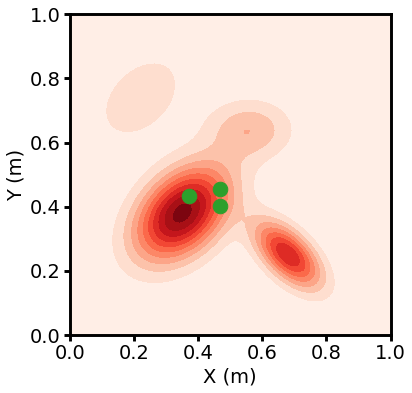

In [ ]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', levels=10)

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 10)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::10], x_traj[:t,1][::10]
    )

    return robot_state, robot_traj,

#ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/10)-1, blit=True, interval=30, repeat=False)
#video = ani.to_html5_video()
#HTML(video)

Step 000 | Loss: 0.038334
Step 050 | Loss: 0.032247
Step 100 | Loss: 0.032211
Step 150 | Loss: 0.032211
Step 200 | Loss: 0.032211
Step 250 | Loss: 0.032211


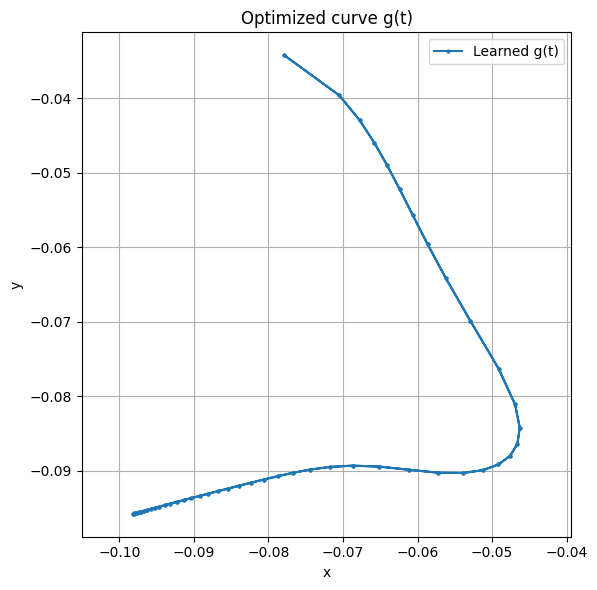

In [ ]:
import numpy as np
from scipy.stats import norm, multivariate_normal as mvn
import matplotlib.pyplot as plt


# Parameters
T = 100  # time steps
K = 50   # number of projection directions
lr = 0.05
steps = 300

# Quantiles to match
taus = np.linspace(0.001, 0.999, T)

# Projection directions
angles = np.linspace(0, 2 * np.pi, K, endpoint=False)
thetas = np.stack([np.cos(angles), np.sin(angles)], axis=1)

# --- Gaussian Mixture Projections ---

def project_gaussians(theta):
    mus = [np.dot(m, theta) for m in means]
    sigmas = [np.sqrt(theta @ cov @ theta) for cov in covs]
    return mus, sigmas

def cdf_mixture_1d(x, mus, sigmas, weights):
    return sum(w * norm.cdf((x - mu) / sigma) for w, mu, sigma in zip(weights, mus, sigmas))

def inverse_cdf_mixture(theta, tau, tol=1e-6, max_iter=100):
    mus, sigmas = project_gaussians(theta)
    lower = min(mus) - 5 * max(sigmas)
    upper = max(mus) + 5 * max(sigmas)
    for _ in range(max_iter):
        mid = 0.5 * (lower + upper)
        val = cdf_mixture_1d(mid, mus, sigmas, weights)
        if abs(val - tau) < tol:
            return mid
        if val < tau:
            lower = mid
        else:
            upper = mid
    return mid

def compute_inverse_cdfs(directions, taus):
    K = len(directions)
    T = len(taus)
    result = np.zeros((K, T))
    for i, theta in enumerate(directions):
        for j, tau in enumerate(taus):
            result[i, j] = inverse_cdf_mixture(theta, tau)
    return result

# Precompute F_mu_theta^{-1}(t)
target_projections = compute_inverse_cdfs(thetas, taus)

# --- Optimization over g(t) in R^2 ---

# Initialize g_t: shape (T, 2)
g = np.random.randn(T, 2) * 0.01

for step in range(steps):
    grad = np.zeros_like(g)  # shape (T, 2)
    
    for k, theta in enumerate(thetas):
        # Project current g along theta → shape (T,)
        g_proj = g @ theta
        
        # Compute error vs. inverse CDF
        diff = g_proj - target_projections[k]  # shape (T,)
        
        # Compute gradient: d/dg_t of <g_t, theta> = theta, so outer product
        grad += 2 * np.outer(diff, theta)  # (T,) x (2,) → (T, 2)

    # Gradient descent update
    g -= lr * grad / K

    # Monitor loss every few steps
    if step % 50 == 0:
        loss = np.mean((g @ thetas.T - target_projections.T) ** 2)
        print(f"Step {step:03d} | Loss: {loss:.6f}")

# --- Plot Result ---

plt.figure(figsize=(6, 6))
plt.plot(g[:, 0], g[:, 1], '-o', label='Learned g(t)', markersize=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Optimized curve g(t)")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(g)

[[-0.07787287 -0.03424914]
 [-0.07050543 -0.0396228 ]
 [-0.06778559 -0.04294235]
 [-0.0658032  -0.04597903]
 [-0.06407963 -0.04901612]
 [-0.06241151 -0.05220375]
 [-0.06065665 -0.05567276]
 [-0.05865983 -0.05958516]
 [-0.05619501 -0.0641864 ]
 [-0.05292483 -0.0698572 ]
 [-0.04913394 -0.07628202]
 [-0.04692903 -0.08106328]
 [-0.04629539 -0.08419096]
 [-0.04661057 -0.08638523]
 [-0.04759912 -0.08798384]
 [-0.04915476 -0.08913705]
 [-0.05125579 -0.08990117]
 [-0.05393585 -0.09027554]
 [-0.0572463  -0.09023756]
 [-0.06112057 -0.08984624]
 [-0.06511921 -0.08941909]
 [-0.06871195 -0.08928987]
 [-0.07177783 -0.08946536]
 [-0.07440923 -0.0898199 ]
 [-0.07671118 -0.09025265]
 [-0.07876425 -0.09070617]
 [-0.08062454 -0.09115201]
 [-0.08233213 -0.09157789]
 [-0.0839141  -0.09197986]
 [-0.0853879  -0.09235753]
 [-0.08676455 -0.09271193]
 [-0.08804927 -0.09304413]
 [-0.08924532 -0.09335501]
 [-0.09035364 -0.09364488]
 [-0.09137506 -0.09391404]
 [-0.09231087 -0.0941624 ]
 [-0.09316328 -0.09439046]
 

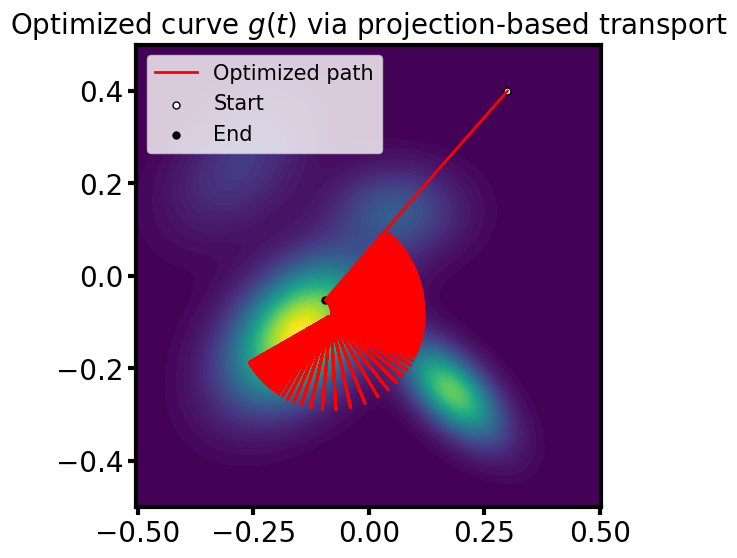

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
from scipy.integrate import cumtrapz

# --- Define the target measure μ as a GMM in R^2 ---

w1, w2, w3, w4 = 0.6, 0.2, 0.1, 0.1

mean1 = np.array([-.15, -.12])
cov1 = np.array([[0.01, 0.004], [0.004, 0.01]])

mean2 = np.array([0.18, -0.25])
cov2 = np.array([[0.005, -0.003], [-0.003, 0.005]])

mean3 = np.array([0.06, 0.14])
cov3 = np.array([[0.008, 0.0], [0.0, 0.004]])

mean4 = np.array([-.28, 0.24])
cov4 = np.array([[0.01, 0.004], [0.004, 0.01]])

components = [(mean1, cov1, w1), (mean2, cov2, w2), (mean3, cov3, w3), (mean4, cov4, w4)]


def gmm_pdf(x):
    """Evaluate the mixture PDF at point(s) x (shape: (N, 2))"""
    return sum(w * mvn(mean, cov).pdf(x) for mean, cov, w in components)


# --- Compute marginal quantile functions for projected directions ---

def compute_inverse_marginals(thetas, N=1000):
    """
    For a set of directions (K, 2), compute the inverse CDFs (quantile functions)
    of the projected GMM along each direction using sampling.
    """
    # Sample from the GMM
    num_samples = 100000
    samples = np.vstack([
        mvn.rvs(mean, cov, size=int(w * num_samples))
        for mean, cov, w in components
    ])

    # Project the samples along each theta and compute empirical quantiles
    quantiles = np.linspace(0.001, 0.999, N)
    inverse_cdfs = []
    for theta in thetas:
        proj = samples @ theta
        proj.sort()
        inverse_cdfs.append(np.quantile(proj, quantiles))
    return np.array(inverse_cdfs), quantiles


# --- Initialize optimization over curve g(t) in R^2 ---

T = 1000                 # number of time steps
K = 150                  # number of projection directions
dt = 0.01               # learning rate
u_max = 0.2           # max step size

# Directions on S^1
angles = np.linspace(0, 2 * np.pi, K, endpoint=False)
thetas = np.stack((np.cos(angles), np.sin(angles)), axis=1)

# Precompute inverse CDFs
inv_cdfs, quantiles = compute_inverse_marginals(thetas, N=T)

# Initialize g(0)
g = np.zeros((T, 2))
g[0] = np.array([0.3, 0.4])  # starting point

# --- Perform greedy control-based optimization step-by-step ---

for t in range(T - 1):
    update = np.zeros(2)
    for k, theta in enumerate(thetas):
        # Current projection
        g_proj = g[t] @ theta

        # Target projection at time t (quantile location)
        F_inv = inv_cdfs[k, t]

        # Discrepancy
        diff = g_proj - F_inv

        # Directional gradient (d/dg <g, theta> = theta)
        update += diff * theta

    # Normalize and apply step
    direction = update / np.linalg.norm(update + 1e-8)
    g[t + 1] = g[t] - u_max * direction

# --- Plot the optimized curve ---
plt.figure(figsize=(6, 6))
plt.contourf(*np.meshgrid(np.linspace(-0.5, 0.5, 200), np.linspace(-0.5, 0.5, 200)),
             gmm_pdf(np.stack(np.meshgrid(np.linspace(-0.5, 0.5, 200),
                                          np.linspace(-0.5, 0.5, 200)), axis=-1).reshape(-1, 2)).reshape(200, 200),
             levels=100, cmap='viridis')
plt.plot(g[:, 0], g[:, 1], 'r-', lw=2, label='Optimized path')
plt.scatter(g[0, 0], g[0, 1], c='white', edgecolor='black', label='Start')
plt.scatter(g[-1, 0], g[-1, 1], c='black', label='End')
plt.axis('equal')
plt.title('Optimized curve $g(t)$ via projection-based transport')
plt.legend()
plt.show()


In [56]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
from scipy.special import ndtri

# --- Target GMM ---
means = [np.array([-.15, -.12]), np.array([0.18, -0.25]),
         np.array([0.06, 0.14]), np.array([-.28, 0.24])]
covs = [np.array([[0.01, 0.004], [0.004, 0.01]]),
        np.array([[0.005, -0.003], [-0.003, 0.005]]),
        np.array([[0.008, 0.0], [0.0, 0.004]]),
        np.array([[0.01, 0.004], [0.004, 0.01]])]
weights = [0.6, 0.2, 0.1, 0.1]

def sample_gmm(n):
    components = np.random.choice(len(weights), size=n, p=weights)
    return np.array([np.random.multivariate_normal(means[i], covs[i]) for i in components])

# --- Setup ---
T = 1000       # time steps
dt = 0.01
K = 5000         # number of directions
N = 20000       # GMM samples
lr = 0.01      # learning rate
ud = 0.2       # control magnitude

# --- Inverse CDF per direction ---
def compute_proj_quantiles(samples, thetas, tsteps):
    F_inv = []
    for theta in thetas:
        proj = samples @ theta
        proj_sorted = np.sort(proj)
        ts = np.linspace(0, 1, tsteps)
        F_inv.append(np.interp(ts, np.linspace(0, 1, len(proj_sorted)), proj_sorted))
    return np.array(F_inv)  # (K, T)

# --- Sample from GMM and precompute inverse projections ---
samples = sample_gmm(N)
thetas = np.stack([np.cos(2*np.pi*np.arange(K)/K), np.sin(2*np.pi*np.arange(K)/K)], axis=1)
target_proj_inv = compute_proj_quantiles(samples, thetas, T)  # (K, T)

# --- Initialize trajectory ---
x_traj = np.zeros((T, 2))
xt = np.zeros((2,))
xt = np.array([-.3,-.3])
metric_log = []
diff = np.zeros(K)

for t in range(T):
    t_frac = (t + 1) / T

    # Step 1: project current xt onto all directions
    xt_proj = thetas @ xt  # shape: (K,)
    
    # Step 2: get target projections for this time
    target_proj = target_proj_inv[:, t]
    # Step 3: compute loss gradient: d/dx <xt, theta> = theta
    diff += xt_proj - target_proj  # shape: (K,)
    grad = np.sum((diff[:, None]) * thetas, axis=0)  # aggregate gradient

    # Step 4: compute control
    ut = -ud * grad / (np.linalg.norm(grad))

    # Step 5: move
    xt = xt + dt * ut
    x_traj[t] = xt.copy()

    # Optional loss monitoring
    if t % 1000 == 0:
        loss = np.mean((xt_proj - target_proj)**2)
        print(f"Step {t:03d} | Loss: {loss:.6f}")

# x_traj now contains the optimized trajectory


Step 000 | Loss: 0.372574


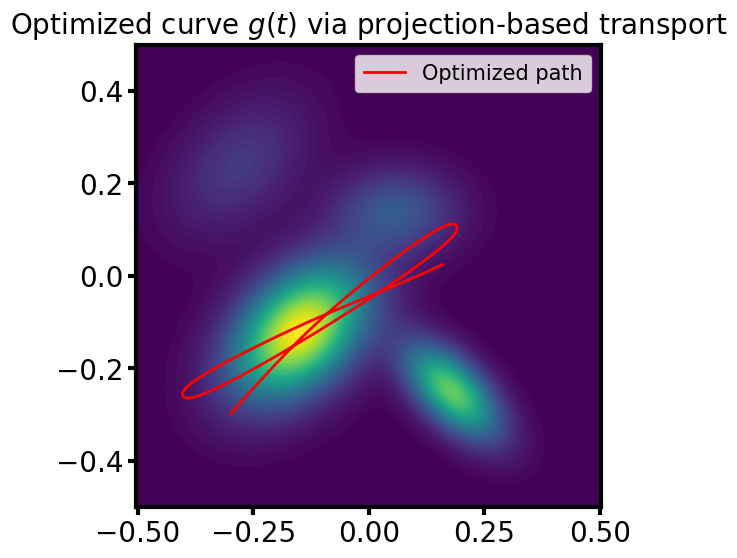

In [57]:
plt.figure(figsize=(6, 6))
plt.contourf(*np.meshgrid(np.linspace(-0.5, 0.5, 200), np.linspace(-0.5, 0.5, 200)),
             gmm_pdf(np.stack(np.meshgrid(np.linspace(-0.5, 0.5, 200),
                                          np.linspace(-0.5, 0.5, 200)), axis=-1).reshape(-1, 2)).reshape(200, 200),
             levels=100, cmap='viridis')
plt.plot(x_traj[:, 0], x_traj[:, 1], 'r-', lw=2, label='Optimized path')
plt.axis('equal')
plt.title('Optimized curve $g(t)$ via projection-based transport')
plt.legend()
plt.show()

In [ ]:
import numpy as np

# --- Setup ---
T = 10000       # time steps
dt = 0.01
K = 1000        # number of projection directions
ud = 0.2        # control magnitude (learning rate)

# --- Directions ---
thetas = np.stack([np.cos(2*np.pi*np.arange(K)/K), np.sin(2*np.pi*np.arange(K)/K)], axis=1)  # shape (K, 2)

# --- Compute inverse CDF of Uniform projection for each direction ---
# Assume uniform over square [-1, 1]^2, so project all 4 corners
corners = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])  # shape (4, 2)
proj_bounds = np.dot(corners, thetas.T)  # shape (4, K)

a_k = np.min(proj_bounds, axis=0)  # shape (K,)
b_k = np.max(proj_bounds, axis=0)  # shape (K,)

ts = np.linspace(0, 1, T)  # time as normalized quantile level
target_proj_inv = a_k[:, None] + ts[None, :] * (b_k - a_k)[:, None]  # shape (K, T)

# --- Initialize trajectory ---
x_traj = np.zeros((T, 2))
xt = np.zeros((2,))
metric_log = []
diff = np.zeros(K)
for t in range(T):
    # Step 1: project current xt onto all directions
    xt_proj = thetas @ xt  # shape: (K,)
    
    # Step 2: get target projections for this time
    target_proj = target_proj_inv[:, t]

    # Step 3: compute projection mismatch
    diff += xt_proj - target_proj  # shape: (K,)

    # Step 4: informed control step using projection mismatch
    ut = -ud * np.sum((diff[:, None]) * thetas, axis=0)  # shape: (2,)

    # Step 5: apply first-order dynamics
    xt = xt + dt * ut
    x_traj[t] = xt.copy()

    # Optional loss monitoring
    if t % 1000 == 0:
        loss = np.mean(diff**2)
        print(f"Step {t:05d} | Loss: {loss:.6f}")

# x_traj contains the optimized trajectory to match the uniform (Lebesgue) measure


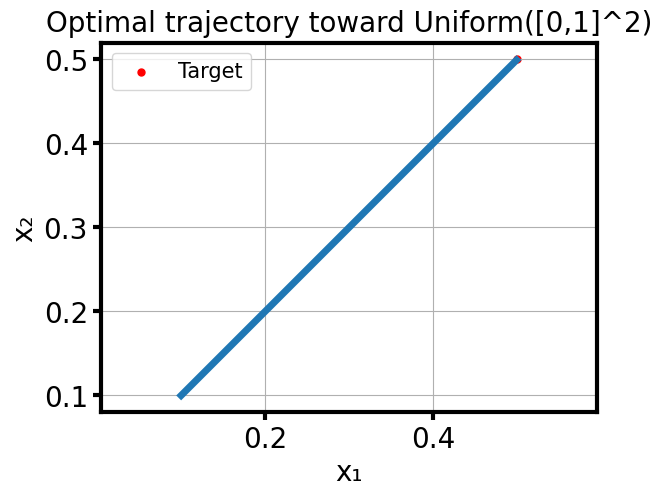

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Initial point
x0 = np.array([0.1, .1])  # for example
T = 2.0
dt = 0.01
steps = int(T / dt)
x = np.zeros((steps, 2))
x[0] = x0

for t in range(1, steps):
    x[t] = x[t-1] - np.pi * (x[t-1] - 0.5) * dt

# Plot
plt.plot(x[:, 0], x[:, 1], marker='o', markersize=1)
plt.scatter([0.5], [0.5], color='red', label='Target')
plt.title("Optimal trajectory toward Uniform([0,1]^2)")
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


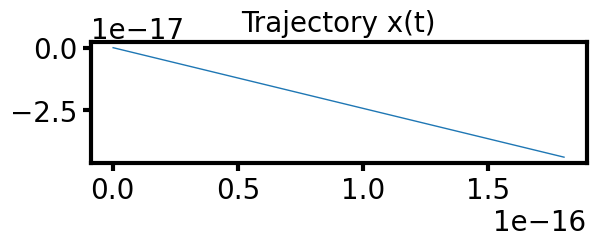

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.stats import norm

# --- Parameters ---
T = 1000                     # Number of time steps
dt = 1.0 / T
d = 2                        # Dimension
K = 100                      # Number of directions
x0 = np.zeros(d)             # Initial point

# --- Directions on unit circle (uniformly spaced) ---
angles = np.linspace(0, 2*np.pi, K, endpoint=False)
thetas = np.stack([np.cos(angles), np.sin(angles)], axis=1)  # (K, 2)

# --- Target measure: uniform on [0, 1]^2 ---
# Projected measure along each direction is uniform on the projection interval.
# We'll precompute F_mu_theta^-1(t) for each direction

def compute_proj_bounds(theta):
    # Corners of [0,1]^2
    corners = np.array([[0,0], [1,0], [0,1], [1,1]])
    projections = corners @ theta
    return projections.min(), projections.max()

# Compute inverse CDFs (quantile functions) of projected marginals
z_k_t = np.zeros((K, T))
dz_k_t = np.zeros((K, T))

ts = np.linspace(0, 1, T)

for k in range(K):
    theta = thetas[k]
    a, b = compute_proj_bounds(theta)  # support of projected uniform
    z_k_t[k] = a + ts * (b - a)
    dz_k_t[k] = (b - a)  # constant derivative

# --- Compute optimal control u(t) from projection derivatives ---
Theta = thetas  # (K, d)
Theta_T_Theta_inv = np.linalg.inv(Theta.T @ Theta)  # (d, d)
x_traj = np.zeros((T, d))
xt = x0.copy()

for t in range(T):
    z_dot = dz_k_t[:, t]  # (K,)
    ut = Theta_T_Theta_inv @ Theta.T @ z_dot  # Optimal velocity
    xt = xt + dt * ut
    x_traj[t] = xt

# --- Plot the trajectory and histogram ---
fig, ax = plt.subplots()
ax.plot(x_traj[:,0], x_traj[:,1], lw=1)
ax.set_title("Trajectory x(t)")
ax.set_aspect('equal')

# Plot final histogram for density check
#fig2, ax2 = plt.subplots()
#ax2.hist2d(x_traj[:,0], x_traj[:,1], bins=30, range=[[0,1],[0,1]], density=True)
#ax2.set_title("Histogram of samples from x(t)")
#ax2.set_aspect('equal')

plt.show()


In [49]:
x_traj

array([[ 1.8041e-19, -4.3802e-20],
       [ 3.6082e-19, -8.7604e-20],
       [ 5.4123e-19, -1.3141e-19],
       ...,
       [ 1.8005e-16, -4.3714e-17],
       [ 1.8023e-16, -4.3758e-17],
       [ 1.8041e-16, -4.3802e-17]])

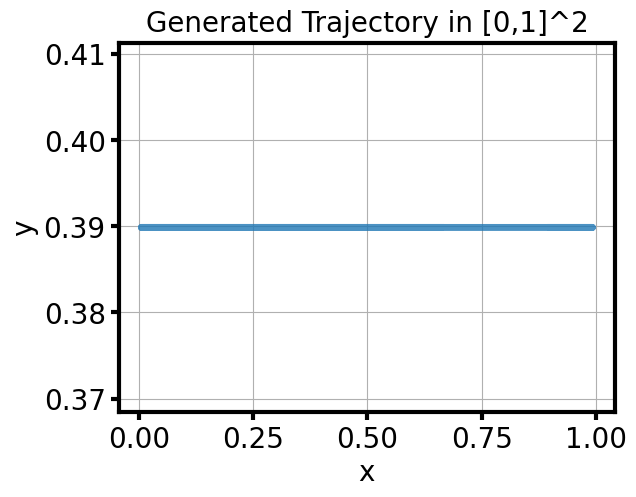

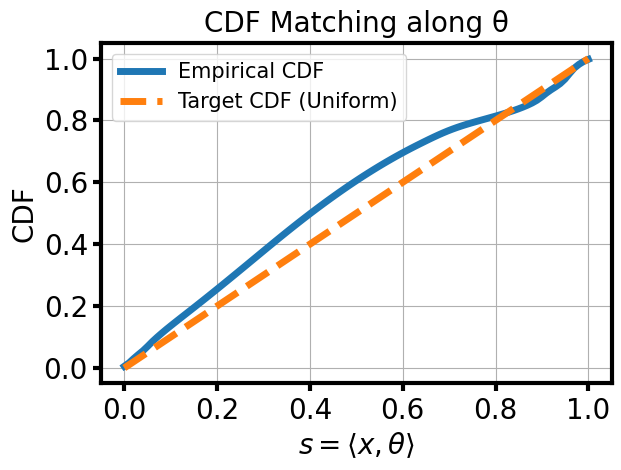

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the online CDF estimator class
class OnlineCDF:
    def __init__(self, s_grid, theta, epsilon=0.01):
        self.s_grid = s_grid
        self.theta = theta / np.linalg.norm(theta)
        self.epsilon = epsilon
        self.t = 0
        self.cdf_vals = np.zeros_like(s_grid)

    def update(self, x_new):
        y = np.dot(x_new, self.theta)
        weights = norm.cdf((self.s_grid - y) / self.epsilon)
        self.cdf_vals = (self.t / (self.t + 1)) * self.cdf_vals + (1 / (self.t + 1)) * weights
        self.t += 1

    def get_cdf(self):
        return self.s_grid, self.cdf_vals

# Target measure: Uniform on [0,1]^2 → marginal projections are also uniform
def target_cdf_uniform(s):
    return np.clip(s, 0, 1)

# Gradient-based optimizer for the control update
def simulate_trajectory_with_cdf_match(T=10000, dt=0.01, eta=0.5):
    d = 2
    theta = np.array([1.0, 0.0])  # project onto x-axis
    s_vals = np.linspace(0, 1, 100)
    cdf_tracker = OnlineCDF(s_vals, theta)

    x = np.zeros((T, d))
    x[0] = np.random.rand(d)

    for t in range(1, T):
        # Get current projected value and update empirical CDF
        cdf_tracker.update(x[t - 1])
        _, empirical_cdf = cdf_tracker.get_cdf()

        # Compute target cdf
        target_cdf = target_cdf_uniform(s_vals)

        # Compute the loss gradient wrt x(t) using chain rule
        proj = np.dot(x[t - 1], theta)
        dphi_ds = -norm.pdf((s_vals - proj) / cdf_tracker.epsilon) / cdf_tracker.epsilon
        loss_grad = 2 * np.trapz((empirical_cdf - target_cdf) * dphi_ds, s_vals)
        grad = -loss_grad * theta

        # Update the trajectory
        x[t] = x[t - 1] + grad * dt

    return x, s_vals, cdf_tracker.get_cdf()[1]

# Run the simulation
trajectory, s_grid, final_cdf = simulate_trajectory_with_cdf_match()

# Plot the results
plt.figure()
plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.8)
plt.title("Generated Trajectory in [0,1]^2")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)

plt.figure()
plt.plot(s_grid, final_cdf, label="Empirical CDF")
plt.plot(s_grid, target_cdf_uniform(s_grid), '--', label="Target CDF (Uniform)")
plt.title("CDF Matching along θ")
plt.xlabel(r"$s = \langle x, \theta \rangle$")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


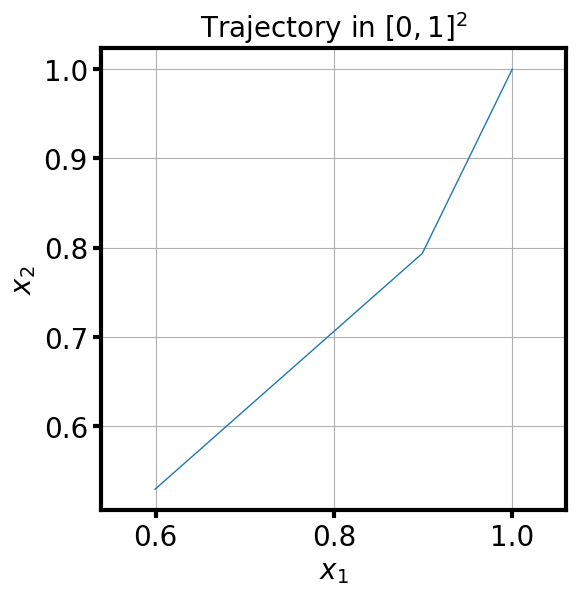

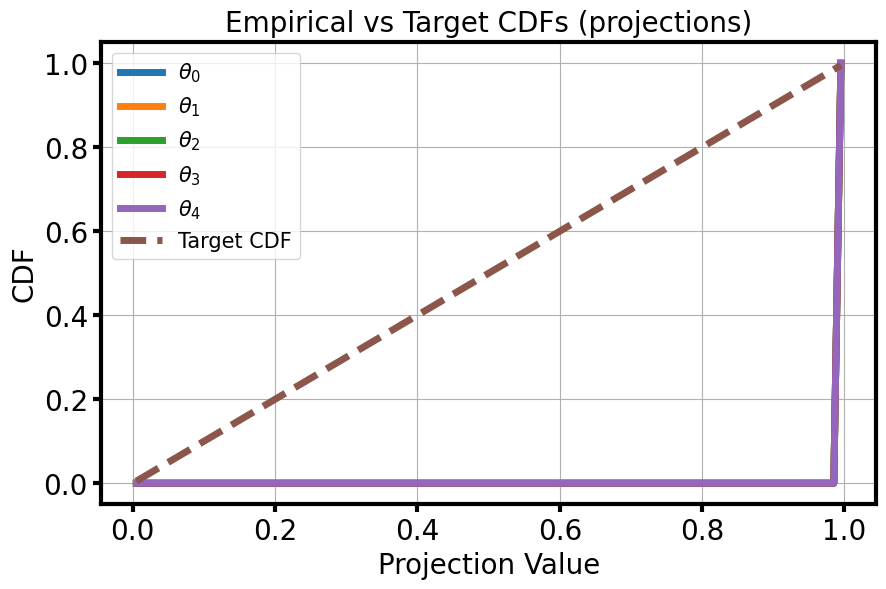

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.interpolate import interp1d

# Parameters
T = 10000  # number of time steps
d = 2     # dimension of the space
n_directions = 100  # number of theta directions
learning_rate = 0.01
bins = 100  # for CDF estimation

# Generate theta_k values uniformly on the unit circle (S^1)
angles = np.linspace(0, 2 * np.pi, n_directions, endpoint=False)
thetas = np.stack((np.cos(angles), np.sin(angles)), axis=1)

# Initialize trajectory
x = np.zeros((T, d))
x[0] = np.random.rand(d)

# Target CDF (uniform in 1D)
target_cdf = lambda z: z  # for uniform on [0,1]

# Histogram-based empirical CDF tracker
cdf_hist = np.zeros((n_directions, bins))
bin_edges = np.linspace(0, 1, bins + 1)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Softened histogram update
def update_cdf_hist(cdf_hist, x_proj, thetas, t, bins):
    for i, theta in enumerate(thetas):
        proj = np.dot(x_proj, theta)
        bin_idx = np.searchsorted(bin_edges, proj, side='right') - 1
        bin_idx = np.clip(bin_idx, 0, bins - 1)
        cdf_hist[i, bin_idx] += 1 / T
    return cdf_hist

# Gradient update function
def compute_gradient(x_t, thetas, cdf_hist, bin_centers):
    grad = np.zeros_like(x_t)
    for i, theta in enumerate(thetas):
        proj = np.dot(x_t, theta)
        bin_idx = np.searchsorted(bin_edges, proj, side='right') - 1
        bin_idx = np.clip(bin_idx, 0, bins - 1)
        F_empirical = np.sum(cdf_hist[i, :bin_idx])
        F_target = target_cdf(proj)
        diff = F_empirical - F_target
        grad += diff * theta
    return grad

# Optimization loop
for t in range(1, T):
    grad = compute_gradient(x[t-1], thetas, cdf_hist, bin_centers)
    x[t] = x[t-1] - dt * grad
    x[t] = np.clip(x[t], 0, 1)  # keep trajectory in [0,1]^2
    cdf_hist = update_cdf_hist(cdf_hist, x[t], thetas, t, bins)

# Plot trajectory
plt.figure(figsize=(6, 6))
plt.plot(x[:, 0], x[:, 1], lw=1)
plt.title("Trajectory in $[0,1]^2$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)
plt.axis('equal')
plt.show()

# Plot empirical vs target CDFs for a few thetas
plt.figure(figsize=(10, 6))
for i in range(min(5, n_directions)):
    plt.plot(bin_centers, np.cumsum(cdf_hist[i]), label=f"$\\theta_{i}$")
plt.plot(bin_centers, bin_centers, '--', label="Target CDF")
plt.title("Empirical vs Target CDFs (projections)")
plt.xlabel("Projection Value")
plt.ylabel("CDF")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\JP\AppData\Local\Temp\ipykernel_29508\3448806129.py:27: RuntimeWarning: invalid value encountered in divide
  v_hat_x = v_x / norm
C:\Users\JP\AppData\Local\Temp\ipykernel_29508\3448806129.py:28: RuntimeWarning: invalid value encountered in divide
  v_hat_y = v_y / norm


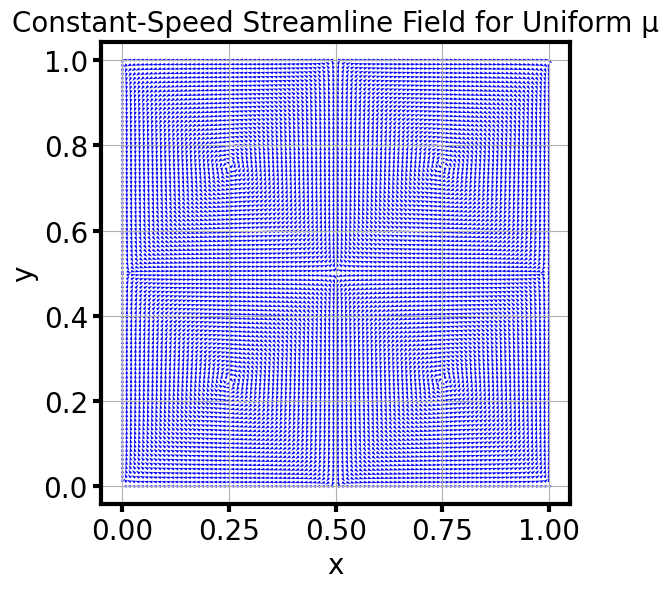

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid
N = 100
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)

# Target measure: uniform on [0,1]^2
mu = np.ones_like(X)

# Define stream function ψ(x, y)
# For uniform measure, use something smooth and periodic to fill space
# e.g., simple periodic stream function to induce a vector field
psi = np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y)

# Compute the vector field: v = ∇^⊥ ψ = (-∂ψ/∂y, ∂ψ/∂x)
dpsi_dx = 2 * np.pi * np.cos(2 * np.pi * X) * np.sin(2 * np.pi * Y)
dpsi_dy = 2 * np.pi * np.sin(2 * np.pi * X) * np.cos(2 * np.pi * Y)

v_x = -dpsi_dy
v_y = dpsi_dx

# Normalize the vector field to get unit directions
norm = np.sqrt(v_x**2 + v_y**2)
v_hat_x = v_x / norm
v_hat_y = v_y / norm

# Constant speed
u_max = 0.2
v_field_x = u_max * v_hat_x
v_field_y = u_max * v_hat_y

# Plot the vector field
plt.figure(figsize=(6, 6))
plt.quiver(X, Y, v_field_x, v_field_y, color='blue', scale=20)
plt.title("Constant-Speed Streamline Field for Uniform μ")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

# Define the interpolating functions for the vector field
interp_vx = RegularGridInterpolator((x, y), v_field_x.T, bounds_error=False, fill_value=0.0)
interp_vy = RegularGridInterpolator((x, y), v_field_y.T, bounds_error=False, fill_value=0.0)

# Define the ODE for df/dt = v(f(t))
def trajectory_rhs(t, f):
    fx, fy = f
    vx = interp_vx((fx, fy))
    vy = interp_vy((fx, fy))
    return [vx, vy]

# Initial condition
f0 = [0.1, 0.1]
t_span = (0, 50)  # total simulation time


C:\Users\JP\AppData\Local\Temp\ipykernel_29508\1090490667.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[0] = np.random.rand(1) # Start from the middle


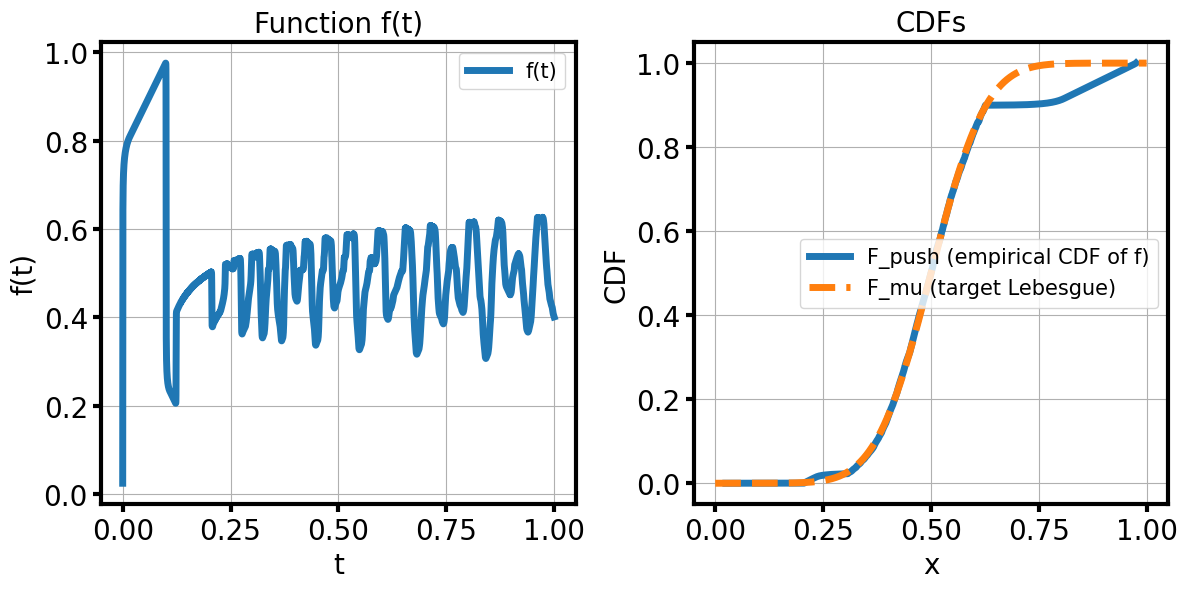

In [327]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm

# Set random seed for reproducibility
# Parameters
T = 10000  # number of time steps
t_grid = np.linspace(0, 1, T)
dt = 0.01
v_max = 0.2 * T * dt   # maximum speed

# Target measure: uniform on [0, 1], so target CDF is F_mu(x) = x
mu, sigma = 0.5, 0.1
F_mu = lambda x: np.clip(norm.cdf(x, loc=mu, scale=sigma), 0, 1)
thres = 1e-3
# Initialize f(t)
f = np.zeros(T)
f[0] = np.random.rand(1) # Start from the middle

# Evolve f(t) using sign update
for i in range(1, T):
    # Empirical CDF of previous values
    F_push = np.mean(f[:i] <= f[i-1])  # eCDF at f[i-1]
    #tau = 0.01  # smoothing factor
    #F_push = np.mean(1 / (1 + np.exp(-(f[:i] - f[i-1]) / tau)))
    delta = (F_push - F_mu(f[i-1]) - 1e-6)
    delta = np.sign(delta) * np.maximum(np.abs(delta), thres)
    direction = np.sign(delta)
    f[i] = f[i-1] + dt * v_max * delta

# Compute the pushforward CDF using the eCDF of f
sorted_f = np.sort(f)
ecdf_y = np.linspace(0, 1, T)

# Plotting
plt.figure(figsize=(12, 6))

# Plot f(t)
plt.subplot(1, 2, 1)
plt.plot(t_grid, f, label="f(t)")
plt.title("Function f(t)")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.grid(True)
plt.legend()

# Plot CDFs
plt.subplot(1, 2, 2)
plt.plot(sorted_f, ecdf_y, label="F_push (empirical CDF of f)")
plt.plot(t_grid, F_mu(t_grid), label="F_mu (target Lebesgue)", linestyle="--")
plt.title("CDFs")
plt.xlabel("x")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\JP\AppData\Local\Temp\ipykernel_29508\1444631803.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[0] = np.random.rand(1) # Start from the middle


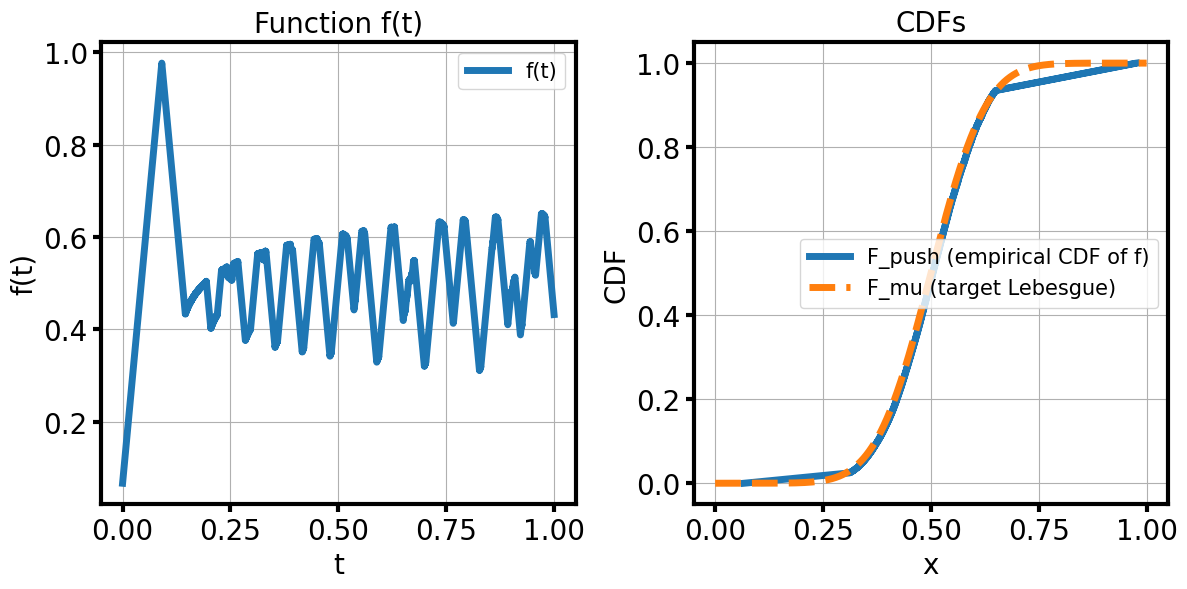

In [328]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm

# Set random seed for reproducibility
# Parameters
T = 10000  # number of time steps
t_grid = np.linspace(0, 1, T)
dt = t_grid[1] - t_grid[0]
v_max = 10  # maximum speed

# Target measure: uniform on [0, 1], so target CDF is F_mu(x) = x
mu, sigma = 0.5, 0.1
F_mu = lambda x: np.clip(norm.cdf(x, loc=mu, scale=sigma), 0, 1)

# Initialize f(t)
f = np.zeros(T)
f[0] = np.random.rand(1) # Start from the middle

# Evolve f(t) using sign update
for i in range(1, T):
    # Empirical CDF of previous values
    F_push = np.mean(f[:i] <= f[i-1])  # eCDF at f[i-1]
    delta = F_push - F_mu(f[i-1]) - 1e-6
    direction = np.sign(delta)
    f[i] = f[i-1] + dt * v_max * direction

# Compute the pushforward CDF using the eCDF of f
sorted_f = np.sort(f)
ecdf_y = np.linspace(0, 1, T)

# Plotting
plt.figure(figsize=(12, 6))

# Plot f(t)
plt.subplot(1, 2, 1)
plt.plot(t_grid, f, label="f(t)")
plt.title("Function f(t)")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.grid(True)
plt.legend()

# Plot CDFs
plt.subplot(1, 2, 2)
plt.plot(sorted_f, ecdf_y, label="F_push (empirical CDF of f)")
plt.plot(t_grid, F_mu(t_grid), label="F_mu (target Lebesgue)", linestyle="--")
plt.title("CDFs")
plt.xlabel("x")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [308]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
dt = 0.01
tsteps = 20000
t_grid = np.arange(tsteps) * dt
v_max = 10 * T * dt   # maximum speed

# Define target distribution
mu, sigma = 0.5, 0.1
F_mu = lambda x: np.clip(norm.cdf(x, loc=mu, scale=sigma), 0, 1)
rho_mu = lambda x: norm.pdf(x, loc=mu, scale=sigma)
# Initialize f(t)
f = np.zeros(tsteps)
f[0] = np.random.rand()  # Initial point

# Evolve f(t) using derived optimal f'(t)
for i in range(1, tsteps):
    x = f[i-1]
    # Empirical CDF difference (Delta = F_push - F_mu)
    F_push = np.mean(f[:i] <= x)
    delta = (F_push - F_mu(f[i-1]) - 1e-6)

    # Avoid division by zero or very small densities
    density = rho_mu(x)
    if density < 1e-8:
        f_prime = 1e6
    else:
        f_prime = delta / (density*dt) #+ 1 / (2 * density)

    # Update f using constrained maximum speed
    f[i] = f[i-1] + dt * np.sign(f_prime) * v_max

# Compute the pushforward CDF using the eCDF of f
sorted_f = np.sort(f)
ecdf_y = np.linspace(0, 1, tsteps)

# Output for visualization
sorted_f[:5], ecdf_y[:5], f[:5]


(array([ 0.5899, 10.5899, 20.5899, 30.5899, 40.5899]),
 array([0.0000e+00, 5.0003e-05, 1.0001e-04, 1.5001e-04, 2.0001e-04]),
 array([ 0.5899, 10.5899, 20.5899, 30.5899, 40.5899]))

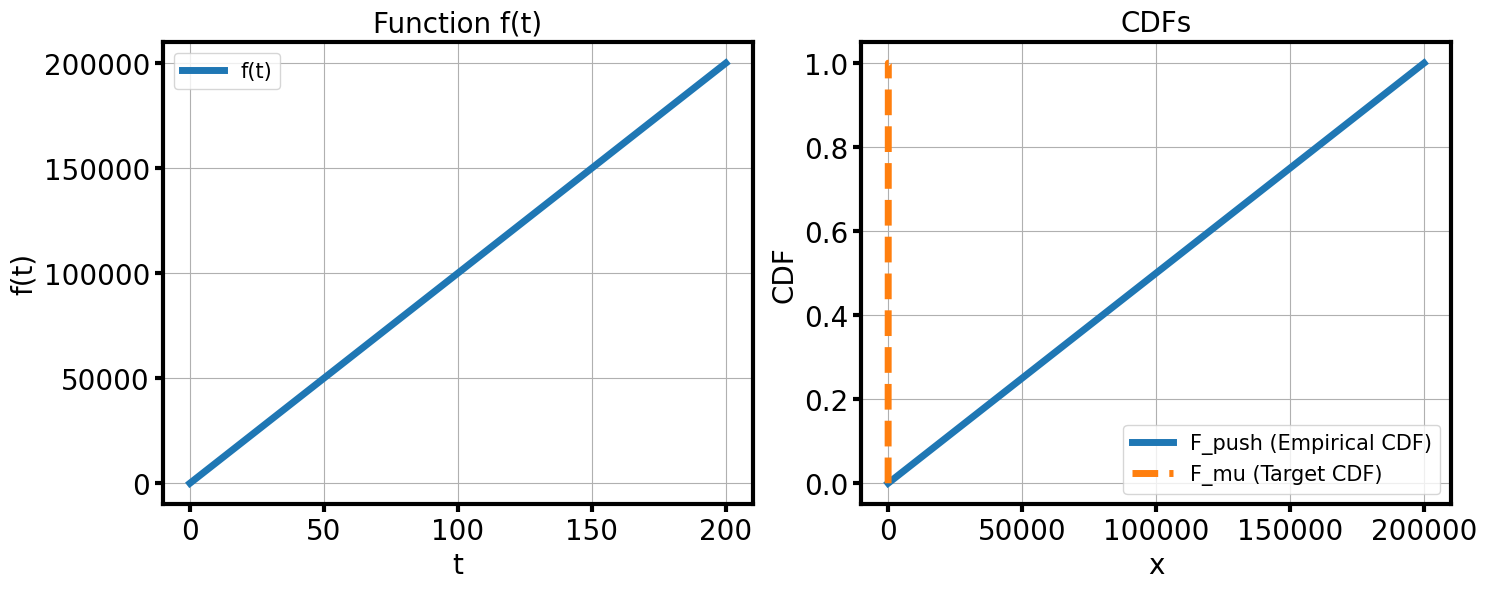

In [309]:

plt.figure(figsize=(15, 6))

# Plot f(t)
plt.subplot(1, 2, 1)
plt.plot(t_grid, f, label="f(t)")
plt.title("Function f(t)")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.grid(True)
plt.legend()

# Plot empirical CDF vs target CDF
plt.subplot(1, 2, 2)
plt.plot(sorted_f, ecdf_y, label="F_push (Empirical CDF)")
plt.plot(t_grid, F_mu(t_grid), '--', label="F_mu (Target CDF)")
plt.title("CDFs")
plt.xlabel("x")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()
plt.legend()
plt.tight_layout()
plt.show()

379.430010107541
383.668394163464
388.1072609942364
392.7551594929129
397.6210288694232
402.7142172181975
408.0445010066523
413.6221055271755
419.4577263667508
425.562551944865
431.9482871733078
438.6271783005517
445.6120389974992
452.91627774554775
460.5539266089014
468.53967144260605
476.88888363144434
485.6176534220999
494.7428249437522
504.28203300172595
514.2537417327736
524.677285228385
535.5729102204571
546.9618209450047
558.8662262947182
571.3093893812618
584.3156796394076
597.9106275996369
612.1209824790292
626.9747727348381
642.501369742333
658.7315547559762
675.6975893423078
693.4332894579303
711.9741033721737
731.3571936429598
751.6215233627449
772.8079469017941
794.9593053914325
818.1205272127105
842.3387337412037
867.6633506557791
894.1462250947062
921.8417489934409
950.8069889207354
981.1018227841626
1012.7890837750034
1045.934711945083
1080.607913840556
1116.8813306172258
1154.831215141431
1194.537618512615
1236.084586587661
1279.5603670238393
1325.0576274196821
1372.67

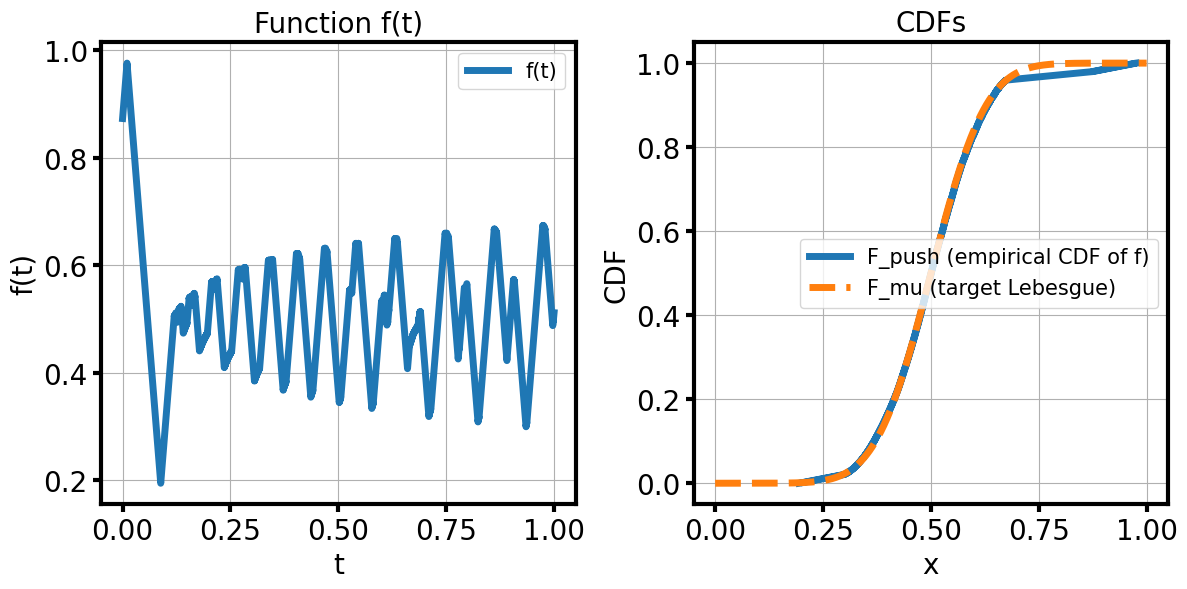

In [346]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm

# Set random seed for reproducibility
# Parameters
T = 10000  # number of time steps
t_grid = np.linspace(0, 1, T)
dt = t_grid[1] - t_grid[0]
v_max = 10  # maximum speed

# Define target distribution
mu, sigma = 0.5, 0.1
F_mu = lambda x: np.clip(norm.cdf(x, loc=mu, scale=sigma), 0, 1)
rho_mu = lambda x: norm.pdf(x, loc=mu, scale=sigma)
# Initialize f(t)
f = np.zeros(T)
f[0] = np.random.rand()  # Initial point

# Evolve f(t) using sign update
for i in range(1, T):
    # Empirical CDF of previous values
    F_push = np.mean(f[:i] <= f[i-1])  # eCDF at f[i-1]
    delta = F_push - F_mu(f[i-1]) - 1e-6
    direction = np.sign(delta)
    density = rho_mu(f[i-1])

    if density < 1e-8:
        f_prime = 1e6
    else:
        f_prime = np.sign(delta) * np.abs(delta / (density*dt) + 1 / (2 * density))
    print(f_prime)
    #direction = np.sign(f_prime)    
    f[i] = f[i-1] + dt * np.sign(f_prime) * v_max #* direction

# Compute the pushforward CDF using the eCDF of f
sorted_f = np.sort(f)
ecdf_y = np.linspace(0, 1, T)

# Plotting
plt.figure(figsize=(12, 6))

# Plot f(t)
plt.subplot(1, 2, 1)
plt.plot(t_grid, f, label="f(t)")
plt.title("Function f(t)")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.grid(True)
plt.legend()

# Plot CDFs
plt.subplot(1, 2, 2)
plt.plot(sorted_f, ecdf_y, label="F_push (empirical CDF of f)")
plt.plot(t_grid, F_mu(t_grid), label="F_mu (target Lebesgue)", linestyle="--")
plt.title("CDFs")
plt.xlabel("x")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the identity map: f(t) = t
# Assume uniform sampling in [0, 1]
N = 100000
t_vals = np.linspace(0, 1, N)
f_vals = t_vals  # identity function
# Compute segments
segments = []
T = t_vals[-1] - t_vals[0]
for i in range(N - 1):
    f1, f2 = f_vals[i], f_vals[i + 1]
    dt = t_vals[i + 1] - t_vals[i]
    segments.append((f1, f2, dt))

# Evaluate the density rho_nu over a grid of y values
y_vals = np.linspace(0, 1, 500)
rho_vals = []

def rho_nu(y, segments, T):
    rho = 0
    for f1, f2, dt in segments:
        if min(f1, f2) <= y <= max(f1, f2):
            rho += dt / (T * abs(f2 - f1))
    return rho

for y in y_vals:
    rho_vals.append(rho_nu(y, segments, T))

# Plot the density
plt.plot(y_vals, rho_vals)
plt.title(r"Density $\rho_\nu(y)$ for $f(t) = t$")
plt.xlabel("y")
plt.ylabel(r"$\rho_\nu(y)$")
plt.grid(True)
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [355]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
T = 10000           # Time steps
v_max = 200          # Max speed
d = 2               # Dimension
n_dirs = 50         # Number of projection directions

# Projection directions (unit vectors on S^1)
angles = np.linspace(0, 2 * np.pi, n_dirs, endpoint=False)
dirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  # shape: (n_dirs, 2)

# Target 1D Gaussian distribution
mu = np.array([0.5, 0.5])
Sigma = 0.1**2 * np.eye(2)
# Lambda functions
rho_mu = lambda theta, x: norm.pdf(x, loc=theta @ mu, scale=np.sqrt(theta @ Sigma @ theta))
F_mu   = lambda theta, x: norm.cdf(x, loc=theta @ mu, scale=np.sqrt(theta @ Sigma @ theta))

# Initialize f(t) in R^2
f = np.zeros((T, d))
f[0] = rng.uniform(0, 1, size=d)

# Time grid
t_grid = np.linspace(0, 1, T)
dt = t_grid[1] - t_grid[0]

# Evolution of f(t)
for i in range(1, T):
    if i % 100 == 0:
        print(i)
    grad = np.zeros(d)
    for a in dirs:
        proj_prev = f[:i] @ a       # Projected history
        proj_curr = f[i - 1] @ a    # Current projection

        # Empirical CDF in direction a
        F_push = np.mean(proj_prev <= proj_curr)
        delta = F_push - F_mu(a ,proj_curr)

        rho = rho_mu(a,proj_curr)
        if rho < 1e-8:
            df = 1e6
        else:
            df = np.sign(delta) * np.abs(delta / (rho * dt) + 1 / (2 * rho))

        grad += df * a  # Back-project into R^2

    # Normalize and update
    grad_norm = np.linalg.norm(grad)
    if grad_norm > 1e-12:
        grad = grad / grad_norm

    f[i] = f[i - 1] + v_max * dt * grad




100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


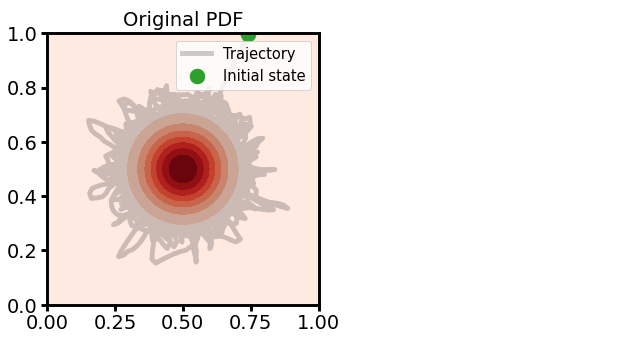

In [354]:
from scipy.stats import multivariate_normal

x = np.linspace(0, 1, 300)
y = np.linspace(0, 1, 300)
grids_x, grids_y = np.meshgrid(x, y)
pos = np.dstack((grids_x, grids_y))
rv = multivariate_normal(mean=mu, cov=Sigma)
pdf_vals = rv.pdf(pos)

# Figure and axis
fig, axes = plt.subplots(1, 2, figsize=(9, 5), dpi=70, tight_layout=True)
ax = axes[0]

# Set aspect and limits
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_title('Original PDF')

# Plot Gaussian PDF as filled contours
ax.contourf(grids_x, grids_y, pdf_vals, cmap='Reds')

# Plot trajectory every 10 points for clarity
ax.plot(f[::1, 0], f[::1, 1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')

# Plot initial point as big green dot
ax.plot(f[0, 0], f[0, 1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')

ax.legend(loc=1)

# If you want to keep the second subplot empty:
axes[1].axis('off')

plt.show()


Step 500/10000
Step 1000/10000
Step 1500/10000
Step 2000/10000
Step 2500/10000
Step 3000/10000
Step 3500/10000
Step 4000/10000
Step 4500/10000
Step 5000/10000
Step 5500/10000
Step 6000/10000
Step 6500/10000
Step 7000/10000
Step 7500/10000
Step 8000/10000
Step 8500/10000
Step 9000/10000
Step 9500/10000


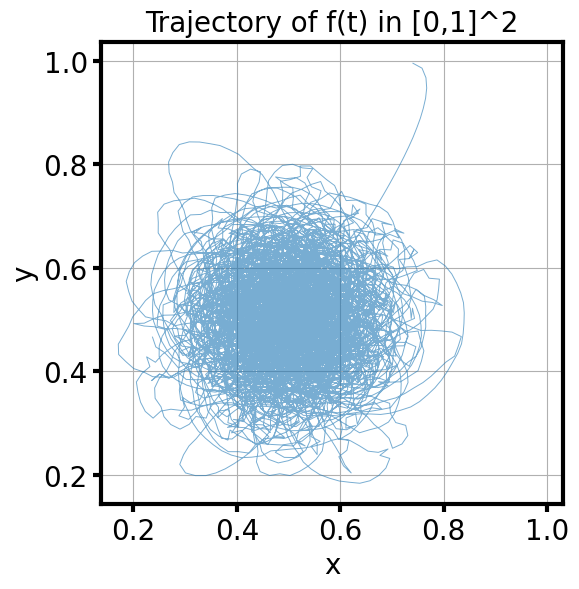

In [356]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
T = 10000           # Time steps
v_max = 200         # Max speed
d = 2               # Dimension
n_dirs = 50         # Number of projection directions
rng = np.random.default_rng(42)

# Uniform source measure on [0,1]^2
X = rng.uniform(0, 1, size=(T, d))

# Projection directions (unit vectors on S^1)
angles = np.linspace(0, 2 * np.pi, n_dirs, endpoint=False)
dirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  # shape: (n_dirs, 2)

# Target 1D Gaussian distribution
mu = np.array([0.5, 0.5])
Sigma = 0.1**2 * np.eye(2)

# Vectorized lambdas for PDF and CDF
def rho_mu(theta, x):
    mean = theta @ mu
    std = np.sqrt(theta @ Sigma @ theta)
    return norm.pdf(x, loc=mean, scale=std)

def F_mu(theta, x):
    mean = theta @ mu
    std = np.sqrt(theta @ Sigma @ theta)
    return norm.cdf(x, loc=mean, scale=std)

# Initialize f(t) in R^2
f = np.zeros((T, d))
f[0] = rng.uniform(0, 1, size=d)

# Time grid
t_grid = np.linspace(0, 1, T)
dt = t_grid[1] - t_grid[0]

# Preallocate projection history buffer
proj_hist = np.zeros((n_dirs, T))

# Evolution of f(t)
for i in range(1, T):
    if i % 500 == 0:
        print(f"Step {i}/{T}")

    grad = np.zeros(d)

    # Project f[:i] onto all directions at once
    proj_hist[:, i] = dirs @ f[i - 1]

    for j, a in enumerate(dirs):
        proj_prev = proj_hist[j, :i]  # shape: (i,)
        proj_curr = proj_hist[j, i]

        # Empirical CDF along direction a
        F_push = np.mean(proj_prev <= proj_curr)
        F_target = F_mu(a, proj_curr)
        delta = F_push - F_target

        rho = rho_mu(a, proj_curr)
        df = delta if rho < 1e-8 else delta  # Simple fallback

        grad += df * a  # Back-project into R^2

    grad_norm = np.linalg.norm(grad)
    if grad_norm > 1e-12:
        grad /= grad_norm

    f[i] = f[i - 1] + v_max * dt * grad
    f[i] = np.clip(f[i], 0, 1)  # Stay within [0,1]^2

# Plot f trajectory
plt.figure(figsize=(6, 6))
plt.plot(f[:, 0], f[:, 1], alpha=0.6, linewidth=0.7)
plt.title("Trajectory of f(t) in [0,1]^2")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("square")
plt.grid(True)
plt.show()


In [359]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
T = 10000            # Time steps
v_max = 200          # Max speed
d = 2                # Dimension
n_dirs = 50          # Number of projection directions
rng = np.random.default_rng(42)

# Uniform source measure on [0,1]^2
X = rng.uniform(0, 1, size=(T, d))

# Projection directions (unit vectors on S^1)
angles = np.linspace(0, 2 * np.pi, n_dirs, endpoint=False)
dirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  # shape: (n_dirs, 2)

# Target 2D Gaussian distribution
mu = np.array([0.5, 0.5])
Sigma = 0.1**2 * np.eye(2)

# Vectorized projected PDF and CDF function
def projected_pdf_cdf(dirs, xt, mu, Sigma):
    proj_xt = dirs @ xt           # shape: (K,)
    proj_mu = dirs @ mu           # shape: (K,)
    proj_var = np.sum((dirs @ Sigma) * dirs, axis=1)  # shape: (K,)
    proj_std = np.sqrt(proj_var)  # shape: (K,)
    pdfs = norm.pdf(proj_xt, loc=proj_mu, scale=proj_std)
    cdfs = norm.cdf(proj_xt, loc=proj_mu, scale=proj_std)
    return pdfs, cdfs, proj_xt

# Initialize f(t) in R^2
f = np.zeros((T, d))
f[0] = rng.uniform(0, 1, size=d)

# Time grid
t_grid = np.linspace(0, 1, T)
dt = t_grid[1] - t_grid[0]

# Evolution of f(t)
for i in range(1, T):
    if i % 1000 == 0:
        print(f"Step {i}/{T}")
    
    # Project past points and current point
    proj_prev = f[:i] @ dirs.T  # shape: (i, n_dirs)
    pdfs, cdfs, proj_xt = projected_pdf_cdf(dirs, f[i-1], mu, Sigma)

    # Compute empirical CDFs in all directions
    F_push = np.mean(proj_prev <= proj_xt, axis=0)  # shape: (n_dirs,)
    deltas = F_push - cdfs

    # Stabilize pdfs
    pdfs = np.maximum(pdfs, 1e-4)

    # Gradient in R^2 via back-projection
    grad = (deltas / pdfs) @ dirs  # shape: (2,)

    # Normalize and update
    grad_norm = np.linalg.norm(grad)
    if grad_norm > 1e-12:
        grad = grad / grad_norm

    f[i] = f[i - 1] + v_max * dt * grad



Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000


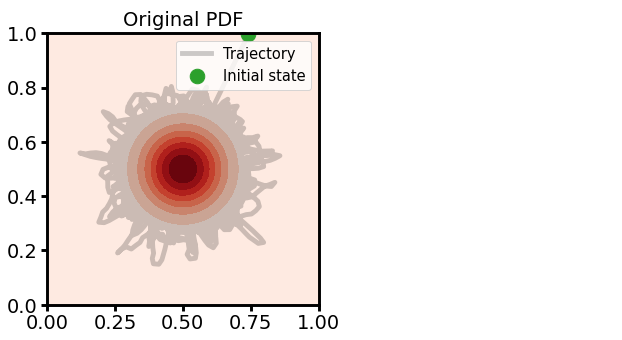

In [360]:
from scipy.stats import multivariate_normal

x = np.linspace(0, 1, 300)
y = np.linspace(0, 1, 300)
grids_x, grids_y = np.meshgrid(x, y)
pos = np.dstack((grids_x, grids_y))
rv = multivariate_normal(mean=mu, cov=Sigma)
pdf_vals = rv.pdf(pos)

# Figure and axis
fig, axes = plt.subplots(1, 2, figsize=(9, 5), dpi=70, tight_layout=True)
ax = axes[0]

# Set aspect and limits
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_title('Original PDF')

# Plot Gaussian PDF as filled contours
ax.contourf(grids_x, grids_y, pdf_vals, cmap='Reds')

# Plot trajectory every 10 points for clarity
ax.plot(f[::1, 0], f[::1, 1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')

# Plot initial point as big green dot
ax.plot(f[0, 0], f[0, 1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')

ax.legend(loc=1)

# If you want to keep the second subplot empty:
axes[1].axis('off')

plt.show()


In [376]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)

In [377]:
import numpy as np
from scipy.stats import norm, multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
T = 10000            # Time steps
v_max = 200          # Max speed
d = 2                # Dimension
n_dirs = 50          # Number of projection directions
# Projection directions (unit vectors on S^1)
angles = np.linspace(0, 2 * np.pi, n_dirs, endpoint=False)
dirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  # shape: (n_dirs, 2)

# Mixture components
means = np.stack([mean1, mean2, mean3, mean4])
covs = np.stack([cov1, cov2, cov3, cov4])
weights = np.array([w1, w2, w3, w4])

def projected_pdf_cdf_mog(dirs, xt, means, covs, weights):
    """
    dirs: (K, 2) projection directions
    xt: (2,) current point
    means: (M, 2)
    covs: (M, 2, 2)
    weights: (M,)
    Returns: pdfs (K,), cdfs (K,), proj_xt (K,)
    """
    K = dirs.shape[0]
    M = means.shape[0]
    # Project xt to each direction
    proj_xt = dirs @ xt            # (K,)
    
    # Project means: (M, K)
    proj_means = means @ dirs.T    # (M, K)
    
    # Project variances: θᵢᵀ Σ θᵢ for each (K, M)
    proj_vars = np.zeros((M, K))
    for m in range(M):
        Sigma_m = covs[m]  # (2, 2)
        proj_vars[m] = np.sum(dirs @ Sigma_m * dirs, axis=1)  # (K,)

    proj_stds = np.sqrt(proj_vars + 1e-12)  # (M, K), numerical stability

    # Compute PDF and CDF for each component at proj_xt: (M, K)
    proj_xt_expand = proj_xt[None, :]  # (1, K)
    pdfs = norm.pdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)
    cdfs = norm.cdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)

    # Weighted sum over components
    weighted_pdfs = (weights[:, None] * pdfs).sum(axis=0)  # (K,)
    weighted_cdfs = (weights[:, None] * cdfs).sum(axis=0)  # (K,)

    return weighted_pdfs, weighted_cdfs, proj_xt
# Initialize f(t) in R^2
f = np.zeros((T, d))
f[0] = rng.uniform(0, 1, size=d)

# Time grid
t_grid = np.linspace(0, 1, T)
dt = t_grid[1] - t_grid[0]

# Evolution of f(t)
for i in range(1, T):
    if i % 1000 == 0:
        print(f"Step {i}/{T}")
    
    # Project past points and current point
    proj_prev = f[:i] @ dirs.T  # shape: (i, n_dirs)
    pdfs, cdfs, proj_xt = projected_pdf_cdf_mog(dirs, f[i-1], means, covs, weights)

    # Compute empirical CDFs in all directions
    F_push = np.mean(proj_prev <= proj_xt, axis=0)  # shape: (n_dirs,)
    deltas = F_push - cdfs

    # Stabilize pdfs
    pdfs = np.maximum(pdfs, 1e-4)

    # Gradient in R^2 via back-projection
    grad = (deltas / pdfs) @ dirs  # shape: (2,)

    # Normalize and update
    grad_norm = np.linalg.norm(grad)
    if grad_norm > 1e-12:
        grad = grad / grad_norm

    f[i] = f[i - 1] + v_max * dt * grad




Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000


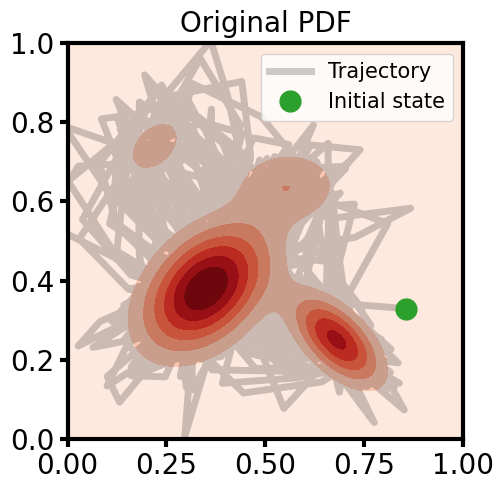

In [387]:
from scipy.stats import multivariate_normal

L_list = np.array([1.0, 1.0])  # boundaries for each dimension
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
pdf_vals = pdf(grids)

fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)

ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(f[::10,0], f[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(f[0,0], f[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

In [401]:
import numpy as np

class OnlineEmpiricalCDF:
    def __init__(self, n_cdfs, n_bins=50, value_range=(-1.0, 1.0)):
        """
        n_cdfs: number of CDFs to track (e.g., number of projection directions)
        n_bins: number of histogram bins
        value_range: (min_val, max_val) range of expected values
        """
        self.K = n_cdfs
        self.n_bins = n_bins
        self.vmin, self.vmax = value_range

        self.bin_edges = np.linspace(self.vmin, self.vmax, n_bins + 1)
        self.bin_counts = np.zeros((self.K, n_bins), dtype=np.int32)
        self.total_counts = np.zeros(self.K, dtype=np.int32)

    def _bin_indices(self, values):
        # Map values to histogram bin indices
        scaled = (values - self.vmin) / (self.vmax - self.vmin)
        indices = np.floor(scaled * self.n_bins).astype(np.int32)
        return np.clip(indices, 0, self.n_bins - 1)

    def update(self, values):
        """
        values: array of shape (K,) — new projected values (one per CDF)
        """
        assert values.shape == (self.K,), "Input must have shape (n_cdfs,)"
        indices = self._bin_indices(values)
        for k in range(self.K):
            self.bin_counts[k, indices[k]] += 1
            self.total_counts[k] += 1

    def query(self, values):
        """
        values: array of shape (K,) — query CDF values (one per CDF)
        Returns: array of shape (K,) — CDF estimates
        """
        assert values.shape == (self.K,), "Input must have shape (n_cdfs,)"
        indices = self._bin_indices(values)
        cdf_vals = np.zeros(self.K)
        for k in range(self.K):
            count = self.bin_counts[k, :indices[k]].sum()
            total = self.total_counts[k]
            cdf_vals[k] = count / total if total > 0 else 0.0
        return cdf_vals


In [411]:
# Parameters
dt_emp = 0.01
T = 20000
dt = 1/T            # Time steps
v_max = 0.2 * dt_emp * T # Max speed
d = 2                # Dimension
n_dirs = 50          # Number of projection directions
# Projection directions (unit vectors on S^1)
angles = np.linspace(0, 2 * np.pi, n_dirs, endpoint=False)
dirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  # shape: (n_dirs, 2)

# Mixture components
means = np.stack([mean1, mean2, mean3, mean4])
covs = np.stack([cov1, cov2, cov3, cov4])
weights = np.array([w1, w2, w3, w4])

def projected_pdf_cdf_mog(dirs, xt, means, covs, weights):
    """
    dirs: (K, 2) projection directions
    xt: (2,) current point
    means: (M, 2)
    covs: (M, 2, 2)
    weights: (M,)
    Returns: pdfs (K,), cdfs (K,), proj_xt (K,)
    """
    K = dirs.shape[0]
    M = means.shape[0]
    # Project xt to each direction
    proj_xt = dirs @ xt            # (K,)
    
    # Project means: (M, K)
    proj_means = means @ dirs.T    # (M, K)
    
    # Project variances: θᵢᵀ Σ θᵢ for each (K, M)
    proj_vars = np.zeros((M, K))
    for m in range(M):
        Sigma_m = covs[m]  # (2, 2)
        proj_vars[m] = np.sum(dirs @ Sigma_m * dirs, axis=1)  # (K,)

    proj_stds = np.sqrt(proj_vars + 1e-12)  # (M, K), numerical stability

    # Compute PDF and CDF for each component at proj_xt: (M, K)
    proj_xt_expand = proj_xt[None, :]  # (1, K)
    pdfs = norm.pdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)
    cdfs = norm.cdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)

    # Weighted sum over components
    weighted_pdfs = (weights[:, None] * pdfs).sum(axis=0)  # (K,)
    weighted_cdfs = (weights[:, None] * cdfs).sum(axis=0)  # (K,)

    return weighted_pdfs, weighted_cdfs, proj_xt
# Initialize f(t) in R^2
f = np.zeros((T, d))
f[0] = rng.uniform(0, 1, size=d)

# Time grid
t_grid = np.linspace(0, 1, T)
dt = t_grid[1] - t_grid[0]

emp_cdf = OnlineEmpiricalCDF(n_cdfs=n_dirs, n_bins=200, value_range=(-np.sqrt(2), np.sqrt(2)))
for i in range(1, T):
    if i % 1000 == 0:
        print(f"Step {i}/{T}")

    # Compute model-based PDF, CDF, and projections
    pdfs, cdfs, proj_xt = projected_pdf_cdf_mog(dirs, f[i-1], means, covs, weights)

    # Query empirical CDF estimate at current projections (does NOT include f[i-1])
    F_push = emp_cdf.query(proj_xt)  # shape: (n_dirs,)

    # Update CDF tracker with f[i-1]'s projections (used in future iterations)
    emp_cdf.update(proj_xt)

    # Compare empirical vs. model CDF
    deltas = F_push - cdfs

    # Stabilize PDFs to avoid divide-by-zero
    pdfs = np.maximum(pdfs, 1e-4)

    # Compute gradient in R^2 via backprojection
    #grad = (deltas / pdfs) @ dirs
    #grad = (np.sign(deltas) * np.abs(deltas / (pdfs* dt) + 1 / (2 * pdfs))) @ dirs
    grad = deltas @ dirs
    # Normalize and Euler step
    grad_norm = np.linalg.norm(grad)
    if grad_norm > 1e-12:
        grad = grad / grad_norm

    f[i] = f[i - 1] + v_max * dt * grad


Step 1000/20000
Step 2000/20000
Step 3000/20000
Step 4000/20000
Step 5000/20000
Step 6000/20000
Step 7000/20000
Step 8000/20000
Step 9000/20000
Step 10000/20000
Step 11000/20000
Step 12000/20000
Step 13000/20000
Step 14000/20000
Step 15000/20000
Step 16000/20000
Step 17000/20000
Step 18000/20000
Step 19000/20000


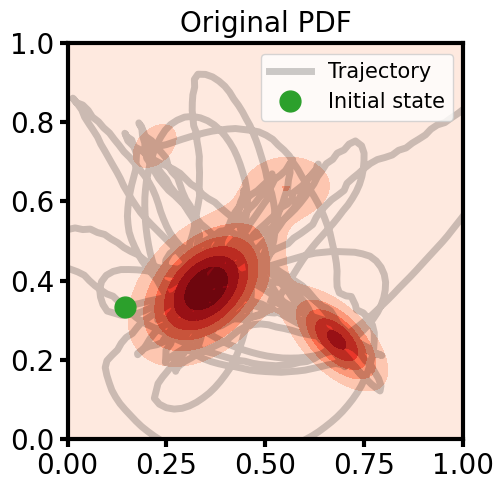

In [412]:
from scipy.stats import multivariate_normal

L_list = np.array([1.0, 1.0])  # boundaries for each dimension
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
pdf_vals = pdf(grids)

fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)

ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(f[::10,0], f[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(f[0,0], f[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()